# create_sigma2_targets

In [1]:
%load_ext autoreload
%autoreload 2

In [54]:
import sys, warnings
# Ignore all warnings
warnings.filterwarnings("ignore")
sys.path.append('../scripts') 
from misc import compute_3d_area
import numpy as np
import xarray as xr
from xhistogram.xarray import histogram
import cftime
import datetime
%matplotlib inline
import matplotlib.pyplot as plt

from mom6_tools  import wright_eos

In [3]:
path_root = '../datasets/'
pi_file = 'woa18_04_initial_conditions.nc'
lgm_file = 'b40.lgm21ka.1deg.003.TEMP_SALT.235101-240012.forMOM6_250122.nc'

### Load ICs

In [5]:
dsPI = xr.open_dataset(path_root+pi_file, decode_times=False)
#dsPI

In [6]:
dsLGM = xr.open_dataset(path_root+lgm_file, decode_times=False)
#dsLGM

### 3D area

In [13]:
area_3d = compute_3d_area(dsPI.lat, dsPI.lon, dsPI.depth)
area3d_masked = area_3d.where(dsPI.theta0[:] == dsPI.theta0[:])
#area3d_masked

### Load initial sigma2 targets

In [14]:
ds_sig = xr.open_dataset(path_root+'hybrid_75layer_zstar2.50m-2020-11-23.nc')

In [15]:
rho_bin_edge  = np.arange(10,45,.05)
rho_bin_cntr = (rho_bin_edge[:-1]+rho_bin_edge[1:])/2.

temp_bin_edge = np.arange(-2,33.001,0.1)
temp_bin_cntr = (temp_bin_edge[:-1]+temp_bin_edge[1:])/2.

salt_bin_edge = np.arange(10,40,0.1)
salt_bin_cntr = (salt_bin_edge[:-1]+salt_bin_edge[1:])/2.

In [16]:
dsPI['area3D'] = area3d_masked
dsPI['area1D'] = dsPI['area3D'].sum(dim=('lat','lon'))

In [17]:
dsLGM['area3D'] = area3d_masked
dsLGM['area1D'] = dsLGM['area3D'].sum(dim=('lat','lon'))

In [19]:
# sigma2
dsPI['rhopot2'] = wright_eos.wright_eos(dsPI['theta0'],dsPI['s_an'],p=2.0e7)-1000.
dsLGM['rhopot2'] = wright_eos.wright_eos(dsLGM['theta0'],dsLGM['s_an'],p=2.0e7)-1000.

In [20]:
hRHO2_PI = histogram(dsPI['rhopot2'], bins=[rho_bin_edge], 
            weights=dsPI['area3D'], dim=['lat','lon'])/(dsPI['area1D'])
hRHO2_LGM = histogram(dsLGM['rhopot2'], bins=[rho_bin_edge], 
            weights=dsLGM['area3D'], dim=['lat','lon'])/(dsLGM['area1D'])

In [21]:
avg_hist_PI = (hRHO2_PI*rho_bin_cntr).sum(dim='rhopot2_bin')
avg_hist_LGM = (hRHO2_LGM*rho_bin_cntr).sum(dim='rhopot2_bin')

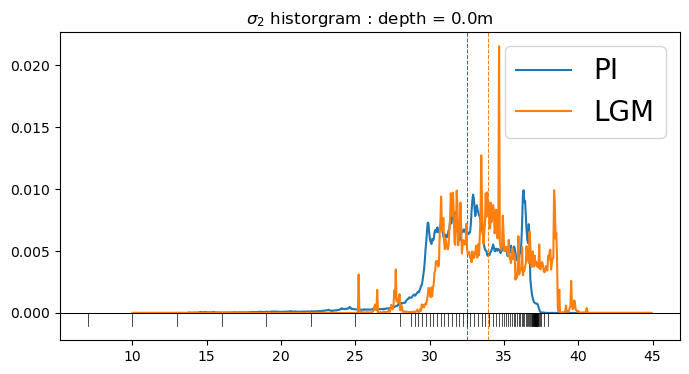

In [22]:
fig,ax=plt.subplots(figsize=(8,4))

p=ax.plot(hRHO2_PI.rhopot2_bin,hRHO2_PI.isel(depth=0),label='PI')
ax.axvline(avg_hist_PI.isel(depth=0),color=p[0].get_color(),linestyle='dashed',linewidth=0.75)
p=ax.plot(hRHO2_LGM.rhopot2_bin,hRHO2_LGM.isel(depth=0),label='LGM')
ax.axvline(avg_hist_LGM.isel(depth=0),color=p[0].get_color(),linestyle='dashed',linewidth=0.75)

ax.axhline(0.0,color='k',linewidth=0.75)

ylim=ax.get_ylim()
for s in ds_sig['sigma2']-1000.:
#    print(s.values)
    x=[s.values,s.values]
    y = [ylim[0],0.0]
    ax.plot(x,y,color='k',linewidth=0.5)

ax.set_title(r'$\sigma_{2}$ historgram : depth = ' + '{:.1f}m'.format(dsPI['depth'].isel(depth=0)))
ax.legend(prop={'size': 20})

#pfile_name = pfile_root + 'surface_sigma2_histogram.png'
#plt.savefig(pfile_name)

In [23]:
dist_PI=dsPI['rhopot2'].where(~np.isnan(dsPI['rhopot2']),drop=True).quantile([0.05,0.5,0.95],dim=('lat','lon'))
dist_LGM=dsLGM['rhopot2'].where(~np.isnan(dsLGM['rhopot2']),drop=True).quantile([0.05,0.5,0.95],dim=('lat','lon'))

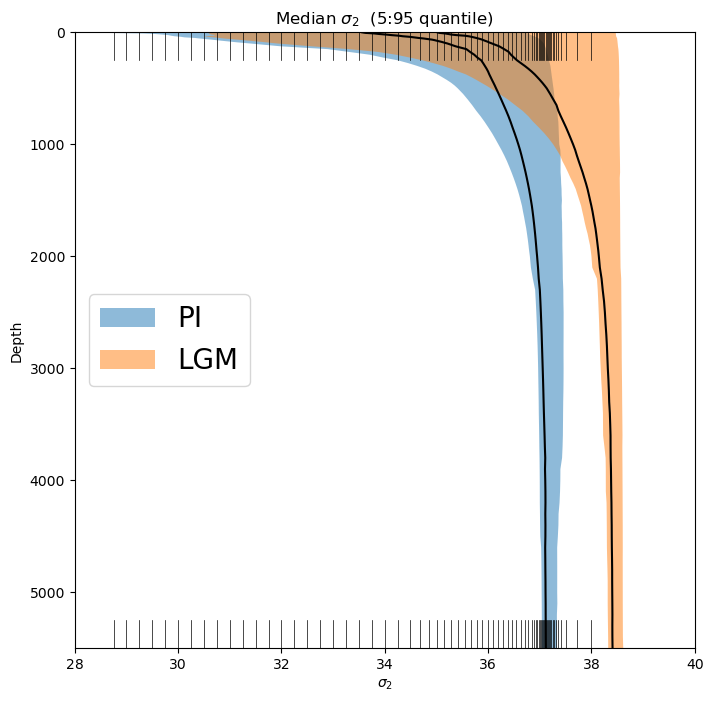

In [24]:
fig,ax=plt.subplots(figsize=(8,8))

ax.fill_betweenx(dist_PI['depth'],dist_PI[0],dist_PI[2],alpha=0.5,label='PI')
ax.plot(dist_PI[1],dist_PI['depth'],color='k')
#ax.plot(avg_hist_PI,ds['z_t']/100.,color='k',linestyle='dashed')
ax.set_xlim(28,40)
ax.set_ylim(5500,0)

ax.fill_betweenx(dist_LGM['depth'],dist_LGM[0],dist_LGM[2],alpha=0.5,label='LGM')
ax.plot(dist_LGM[1],dist_LGM['depth'],color='k')
#ax.plot(avg_hist_LGM,ds['z_t']/100.,color='k',linestyle='dashed')

ax.set_title(r'Median $\sigma_{2}$  (5:95 quantile)')
ax.set_xlabel(r'$\sigma_{2}$')
ax.set_ylabel('Depth')
ax.legend(prop={'size': 20})

for s in ds_sig['sigma2']-1000.:
#    print(s.values)
    x=[s.values,s.values]
    y = [5500,5250]
    ax.plot(x,y,color='k',linewidth=0.5)
    y = [0,250]
    
    ax.plot(x,y,color='k',linewidth=0.5)

#pfile_name = pfile_root + 'sigma2_depth_quantile.png'
#plt.savefig(pfile_name)

### New target density for LGM

In [36]:
sig_pi = (ds_sig['sigma2']-1000.)
sig_lgm = sig_pi.copy() * 0.

#### Step 1) set minum and maximum values

In [37]:
sig_lgm[0]  = sig_pi[0]
sig_lgm[-1] = dist_LGM[2,:].max() + (sig_pi.max() - dist_PI[2,:].max())

#### Step 2) normalize sigma values from 0 to 1

In [41]:
def normalize_da(da, da_min, da_max):
    """
    Normalize a data array using min-max scaling.

    Parameters:
    - da (xarray.DataArray or numpy array): The data array to be normalized.
    - da_min (float or xarray.DataArray): The minimum value of the original data range.
    - da_max (float or xarray.DataArray): The maximum value of the original data range.

    Returns:
    - xarray.DataArray or numpy array: The normalized data array, with values scaled to the range [0, 1].
    """
    normalized = (da - da_min) / (da_max - da_min)
    return normalized

In [43]:
sig_pi_norm = normalize_da(sig_pi, sig_pi.min(), sig_pi.max())
#sig_pi_norm

#### Step 3) denormalize sig_pi_norm using sig_lgm[0], sig_lgm[-1]

In [44]:
def denormalize_da(normalized_da, da_min, da_max):
    """
    Convert a normalized data array back to its original scale.

    Parameters:
    - normalized_da (xarray.DataArray or numpy array): The normalized data array (values between 0 and 1).
    - da_min (float or xarray.DataArray): The original minimum value before normalization.
    - da_max (float or xarray.DataArray): The original maximum value before normalization.

    Returns:
    - xarray.DataArray or numpy array: The denormalized data array, with values restored to the original scale.
    """
    original = normalized_da * (da_max - da_min) + da_min
    return original


In [48]:
sig_lgm_new = denormalize_da(sig_pi_norm, sig_lgm[0], sig_lgm[-1])
#sig_lgm_new

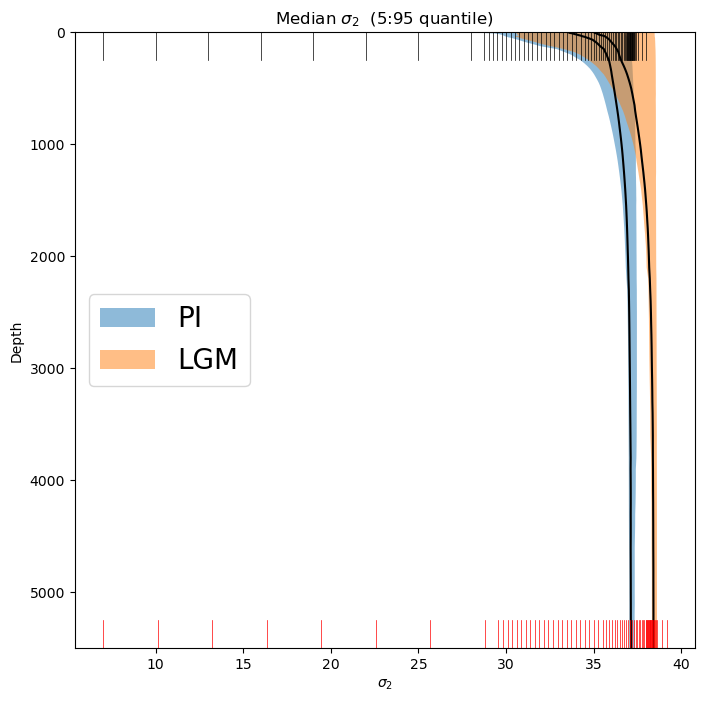

In [49]:
fig,ax=plt.subplots(figsize=(8,8))

ax.fill_betweenx(dist_PI['depth'],dist_PI[0],dist_PI[2],alpha=0.5,label='PI')
ax.plot(dist_PI[1],dist_PI['depth'],color='k')
#ax.plot(avg_hist_PI,ds['z_t']/100.,color='k',linestyle='dashed')
#ax.set_xlim(28,40)
ax.set_ylim(5500,0)

ax.fill_betweenx(dist_LGM['depth'],dist_LGM[0],dist_LGM[2],alpha=0.5,label='LGM')
ax.plot(dist_LGM[1],dist_LGM['depth'],color='k')
#ax.plot(avg_hist_LGM,ds['z_t']/100.,color='k',linestyle='dashed')

ax.set_title(r'Median $\sigma_{2}$  (5:95 quantile)')
ax.set_xlabel(r'$\sigma_{2}$')
ax.set_ylabel('Depth')
ax.legend(prop={'size': 20})

for s in ds_sig['sigma2']-1000.:
#    print(s.values)
    x=[s.values,s.values]
    y = [5500,5250]
    #ax.plot(x,y,color='k',linewidth=0.5)
    y = [0,250]
    
    ax.plot(x,y,color='k',linewidth=0.5)


for s in sig_lgm_new:
#    print(s.values)
    x=[s.values,s.values]
    y = [5500,5250]
    ax.plot(x,y,color='r',linewidth=0.5)
    y = [0,250]
    
    #ax.plot(x,y,color='r',linewidth=0.5)

#pfile_name = pfile_root + 'sigma2_depth_quantile.png'
#plt.savefig(pfile_name)

### Save coordinate

In [52]:
ds_out = ds_sig.copy()
ds_out

<xarray.Dataset> Size: 1kB
Dimensions:  (layers: 75, interfaces: 76)
Dimensions without coordinates: layers, interfaces
Data variables:
    dz       (layers) float64 600B ...
    sigma2   (interfaces) float64 608B 1.007e+03 1.01e+03 ... 1.038e+03
Attributes:
    history:  Created 2020-11-23 16:41:35.566542 with coarsen_84_to74layer.ipynb

In [53]:
ds_out.attrs

{'history': 'Created 2020-11-23 16:41:35.566542 with coarsen_84_to74layer.ipynb'}

In [57]:
today = datetime.date.today().strftime("%y%m%d")
print(today)
fname = f"hybrid_75layer_zstar2.50m_LGM-{today}.nc"
print(fname)

ds_out.attrs['title']  = 'Interface target sigma2 and z* level thickness for MOM6 LGM'
ds_out.attrs['author'] = 'Gustavo Marques (gmarques@ucar.edu)'
ds_out.attrs['initial_sigma2_targets'] = path_root+'hybrid_75layer_zstar2.50m-2020-11-23.nc'
ds_out.attrs['lgm_ic'] = path_root+lgm_file
ds_out.attrs['repo'] = 'https://github.com/gustavo-marques/hycom1-target-tuning/notebooks/'
ds_out.attrs['history'] = f"Created {today} with create_sigma2_targets.ipynb"

ds_out.to_netcdf(f'../datasets/{fname}', format="NETCDF3_64BIT")

250320
hybrid_75layer_zstar2.50m_LGM-250320.nc
